## downloading and conversion to tf_records 


custom functions to download datasets and preprocess them and return the tf_record file. 


only for 2 3 datasets as of now, but others can also be added similarly..

In [0]:
!pip install wget
import wget
import zipfile
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

import tarfile
from six.moves import cPickle as pickle
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


dataset_config = [
    "CIFAR10",
    "MNIST",
    "IMAGENET",
    "TINYIMAGENET"
]


def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))



def mnist_loader():
    def _data_path(data_directory:str, name:str) -> str:

      if not os.path.isdir(data_directory):
          os.makedirs(data_directory)

      return os.path.join(data_directory, f'{name}.tfrecords')

    def _int64_feature(value:int) -> tf.train.Features.FeatureEntry:
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def _bytes_feature(value:str) -> tf.train.Features.FeatureEntry:
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def convert_to(data_set, name:str, data_directory:str, num_shards:int=1):
        print(f'Processing {name} data')

        images = data_set.images
        labels = data_set.labels
        
        num_examples, rows, cols, depth = data_set.images.shape

        def _process_examples(start_idx:int, end_index:int, filename:str):
            with tf.python_io.TFRecordWriter(filename) as writer:
                for index in range(start_idx, end_index):
                    sys.stdout.write(f"\rProcessing sample {index+1} of {num_examples}")
                    sys.stdout.flush()

                    image_raw = images[index].tostring()
                    example = tf.train.Example(features=tf.train.Features(feature={
                        'height': _int64_feature(rows),
                        'width': _int64_feature(cols),
                        'depth': _int64_feature(depth),
                        'label': _int64_feature(int(labels[index])),
                        'image_raw': _bytes_feature(image_raw)
                    }))
                    writer.write(example.SerializeToString())
        
        if num_shards == 1:
            _process_examples(0, data_set.num_examples, _data_path(data_directory, name))
        else:
            total_examples = data_set.num_examples
            samples_per_shard = total_examples // num_shards

            for shard in range(num_shards):
                start_index = shard * samples_per_shard
                end_index = start_index + samples_per_shard
                _process_examples(start_index, end_index, _data_path(data_directory, f'{name}-{shard+1}'))

        print()

    def convert_to_tf_record(data_directory:str):

        mnist = input_data.read_data_sets(
            "/tmp/tensorflow/mnist/input_data", 
            reshape=False
        )
        
        convert_to(mnist.validation, 'validation', data_directory)
        convert_to(mnist.train, 'train', data_directory, num_shards=10)
        convert_to(mnist.test, 'test', data_directory)

    convert_to_tf_record(os.path.expanduser("./"))

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=c5d09ed1da72f0736fab5f07760b583be428552031e6730453d011000e77a02d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
def download_dataset(dataset_name):
    if dataset_name not in dataset_config:
        print(list(dataset_config.keys()))
        msg = "Please enter dataset name from the above dataset list"
        return msg
    else:
        print("Downloading your dataset...")
    
    if(dataset_name == "CIFAR10"):
      return cifar10_loader()

    if(dataset_name == "MNIST"):
      return mnist_loader()

In [0]:
download_dataset("MNIST")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as o

#### Helper functions

1. Parse function : takes in a input tf_record instance, splits the image and label, and then augments using default tf simple augumentations

2. Makedataset function : spicify the path where the tf records are present, this function returns the shuffled batches of tf_record instances.


In [0]:
def parse_fn(example):
  "Parse TFExample records and perform simple data augmentation."
  example_fmt = {
    "image": tf.FixedLengthFeature((), tf.string, ""),
    "label": tf.FixedLengthFeature((), tf.int64, -1)
  }
  parsed = tf.parse_single_example(example, example_fmt)
  image = tf.io.image.decode_image(parsed["image"])
  image = _augment_helper(image)  # augments image using slice, reshape, resize_bilinear
  return image, parsed["label"]

def make_dataset():
  files = tf.data.Dataset.list_files("/path/to/dataset/train-*.tfrecord")
  dataset = tf.data.TFRecordDataset(files)
  dataset = dataset.shuffle(buffer_size=FLAGS.shuffle_buffer_size)
  dataset = dataset.map(map_func=parse_fn)
  dataset = dataset.batch(batch_size=FLAGS.batch_size)
  return dataset

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
dataset = tf.data.Dataset.from_tensor_slices((x_train[0:8] / 255).astype(np.float32))

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(fig_size = (10,10))
def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))

    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
        row += 1

    plt.figure()
    plt.imshow(output)
    plt.show()

In [0]:
def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random_uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

In [0]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

In [0]:
def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

In [0]:
def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))


Instructions for updating:
box_ind is deprecated, use box_indices instead


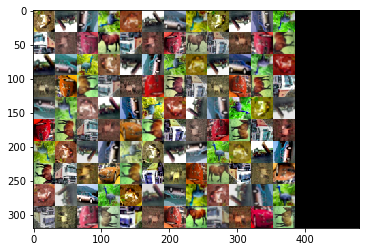

In [0]:
augmentations = [flip, color, zoom, rotate]

# Add the augmentations to the dataset
for f in augmentations:
    # Apply the augmentation, run 4 jobs in parallel.
    dataset = dataset.map(f, num_parallel_calls=4)

# Make sure that the values are still in [0, 1]
dataset = dataset.map(lambda x: tf.clip_by_value(x, 0, 1), num_parallel_calls=4)

plot_images(dataset, n_images=10, samples_per_image=15)

In [0]:
for f in augmentations:
    # Apply an augmentation only in 25% of the cases.
    dataset = dataset.map(lambda x: tf.cond(tf.random_uniform([], 0, 1) > 0.75, lambda: f(x), lambda: x), num_parallel_calls=4)

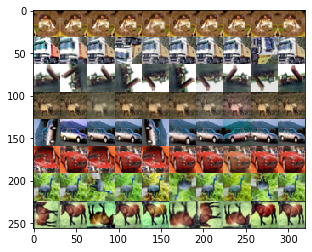

In [0]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))

    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
        row += 1

    plt.figure()
    plt.imshow(output)
    plt.show()

def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random_uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

data = (x_train[0:8] / 255).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data)

# Add augmentations
augmentations = [flip, color, zoom, rotate]

for f in augmentations:
    dataset = dataset.map(lambda x: tf.cond(tf.random_uniform([], 0, 1) > 0.75, lambda: f(x), lambda: x), num_parallel_calls=4)
dataset = dataset.map(lambda x: tf.clip_by_value(x, 0, 1))

plot_images(dataset, n_images=8, samples_per_image=10)